In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
from matplotlib import pyplot as plt
from models import CNN_VAE

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-gzomursb because the default path (/home/mihalis/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
torch.multiprocessing.set_sharing_strategy('file_system') 

In [3]:
# Displaying routine

def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            plt.figure(figsize=(8, 8))            
            imshow(in_)
            plt.axis('off')
            
        plt.figure(figsize=(8, 8))
        imshow(out)
        plt.axis('off')

In [4]:
# Set random seeds

torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [5]:
# Define data loading step

batch_size = 256

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    CIFAR10('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    CIFAR10('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

Files already downloaded and verified


In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

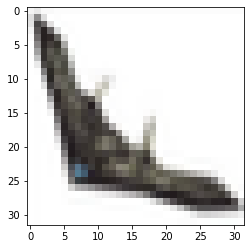

'plane'

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0]))
# print labels
classes[labels[0]]

In [8]:
model = CNN_VAE(3,32,512,256)
dataiter = iter(train_loader)


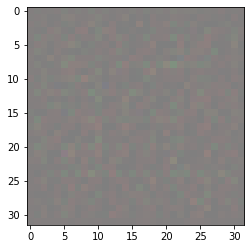

In [9]:
images, labels = dataiter.next()
image,mean,variance = model(images)
imshow(image[0].detach())

/home/mihalis/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


====> Test set loss: 0.7835


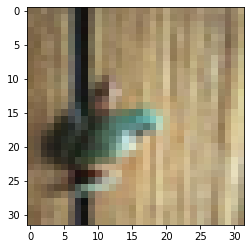

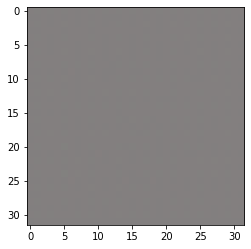

====> Epoch: 1 Average loss: 0.6213
====> Test set loss: 0.5350


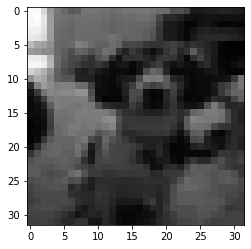

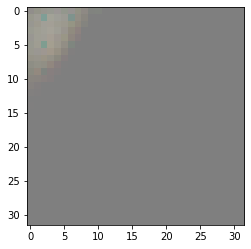

====> Epoch: 2 Average loss: 0.5131
====> Test set loss: 0.4951


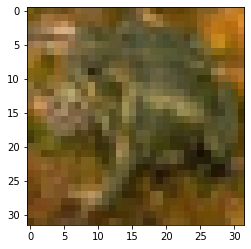

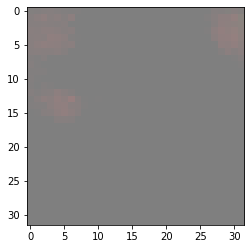

KeyboardInterrupt: 

In [10]:
# Training and testing the VAE

epochs = 10
codes = dict(μ=list(), logσ2=list(), y=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        for image, _ in train_loader:
            # ===================forward=====================
            prediction, mean, variance = model(image)
            # ===================backward====================
            train_loss+= model.backward(prediction,image,mean,variance)
            
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    
    # Testing    
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for image, label in test_loader:
            # ===================forward=====================
            prediction, mean, variance = model(image)
            test_loss += CNN_VAE.loss_function(prediction, image, mean, variance).item()
            # =====================log=======================
            means.append(mean.detach())
            logvars.append(variance.detach())
            labels.append(label.detach())
    # ===================log========================
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    imshow(image.detach()[0])
    imshow(prediction.detach()[0])

In [ ]:
# Generating a few samples

N = 4
z = torch.randn((N, model.latent_size))
sample = model.decoder(z)
display_images(None, sample, N // 4, count=True)

In [ ]:
# Display last test batch

display_images(None, x, 4, count=True)

In [ ]:
# Choose starting and ending point for the interpolation -> shows original and reconstructed

A, B = 1, 15
sample = model.decoder(torch.stack((mu[A].data, mu[B].data), 0))
display_images(None, torch.stack(((
    x[A].data.view(-1),
    x[B].data.view(-1),
    sample.data[0],
    sample.data[1]
)), 0))

In [ ]:
# Perform an interpolation between input A and B, in N steps

N = 16
code = torch.Tensor(N, 20).to(device)
sample = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
    # sample[i] = i / (N - 1) * x[B].data + (1 - i / (N - 1) ) * x[A].data
sample = model.decoder(code)
display_images(None, sample, N // 4, count=True)

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
from res.plot_lib import set_default

In [ ]:
set_default(figsize=(15, 4))

In [ ]:
X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = (0, 5, 10)
for epoch in epochs:
    X.append(codes['μ'][epoch][:N])
    E.append(TSNE(n_components=2).fit_transform(X[-1]))
    Y.append(codes['y'][epoch][:N])

In [ ]:
f, a = plt.subplots(ncols=3)
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:,0], E[i][:,1], c=Y[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)